#### Combining Sampling Methods For Imbalanced Dataset

##### Recap
+ Oversampling: duplicate or create new synthetic values/add to the minority class
+ Undersampling: removing or merging examples in the majority class

#### Methods
+ Manual
    - Using Imblearn Pipelines
    
+ Using Predefined Methods
    - SMOTETomek (Oversampling + Undersampling)
    - SMOTEENN()
    

    
+ Default: removes missclassified examples from all classes
+ You can change sampling strategy to remove from only majority for undersampling

In [ ]:
!pip install imbalanced-learn -q

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import f1_score,matthews_corrcoef


import warnings
warnings.filterwarnings('ignore')

In [2]:
# path = "data/adult_imbalance.csv"
path = "https://frenzy86.s3.eu-west-2.amazonaws.com/python/data/adult_imbalance.csv"

df = pd.read_csv(path)
df

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,class
0,32,2,43403,5,10,2,8,0,0,1,0,1590,54,0,<=50K
1,19,5,182609,1,9,0,11,3,1,1,0,0,25,0,<=50K
2,51,2,332243,0,13,2,3,0,0,0,0,0,45,0,<=50K
3,27,2,158156,1,9,0,4,0,0,1,0,0,42,0,<=50K
4,64,1,170421,5,10,6,6,0,0,1,0,0,8,0,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20495,65,1,118474,2,7,1,1,1,0,0,9386,0,59,4,>50K
20496,39,2,347960,10,15,0,3,0,0,1,14084,0,35,0,>50K
20497,51,2,204447,5,10,1,3,1,0,0,0,0,45,0,>50K
20498,35,2,36214,0,13,1,1,1,0,0,4386,0,47,0,>50K


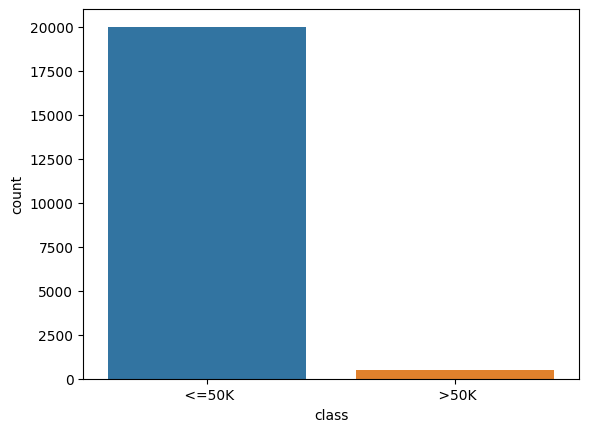

In [3]:
# Visualize Class Distribution
sns.countplot(x='class',data=df,hue='class');

In [4]:
df['class'].unique()

array([' <=50K', ' >50K'], dtype=object)

In [5]:
df['class'] = df['class'].map({' <=50K':0, ' >50K':1})

In [6]:
df.dtypes

,0
age,int64
workclass,int64
fnlwgt,int64
education,int64
education_num,int64
marital_status,int64
occupation,int64
relationship,int64
race,int64
sex,int64


## Combining Sampling Methods

### Method 1: Using imPipeline

In [8]:
from imblearn.pipeline import Pipeline as imPipeline
from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.under_sampling import RandomUnderSampler,TomekLinks,EditedNearestNeighbours

over = RandomOverSampler(sampling_strategy='minority',
                         random_state=667,
                         )
under = RandomUnderSampler(sampling_strategy='majority',
                           random_state=667,
                           )

In [9]:
pipeline_imb = imPipeline([
                          ('over',over),
                          ('under',under)
                          ])
pipeline_imb

Pipeline(steps=[('over',
                 RandomOverSampler(random_state=667,
                                   sampling_strategy='minority')),
                ('under',
                 RandomUnderSampler(random_state=667,
                                    sampling_strategy='majority'))])

In [10]:
X = df[['age', 'workclass', 'fnlwgt', 'education', 'education_num',
        'marital_status', 'occupation', 'relationship', 'race', 'sex',
        'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
        ]]

y = df['class']

In [11]:
X_resampled, y_resampled = pipeline_imb.fit_resample(X,y)

In [12]:
from collections import Counter

print("Original ",X.shape)
print("Balanced X",X_resampled.shape)
print("Original Y",Counter(y))
print("Balanced Y",Counter(y_resampled))

Original  (20500, 14)
Balanced X (40000, 14)
Original Y Counter({0: 20000, 1: 500})
Balanced Y Counter({0: 20000, 1: 20000})


In [13]:
### Cross Value
cv_results_for_manual = cross_val_score(LogisticRegression(),X_resampled,y_resampled,cv=5,scoring='accuracy')
cv_results_for_manual

array([0.673   , 0.67875 , 0.672625, 0.68    , 0.67025 ])

In [14]:
np.mean(cv_results_for_manual)

0.674925

In [15]:
X_train,X_test,y_train,y_test = train_test_split(X_resampled,y_resampled,
                                                 test_size=0.3,
                                                 random_state=667,
                                                 stratify=y_resampled,
                                                 )

In [16]:
lr_model = LogisticRegression()

lr_model.fit(X_train,y_train)

LogisticRegression()

In [17]:
lr_model.score(X_test,y_test)

0.668

Text(98.33159722222221, 0.5, 'predicted label')

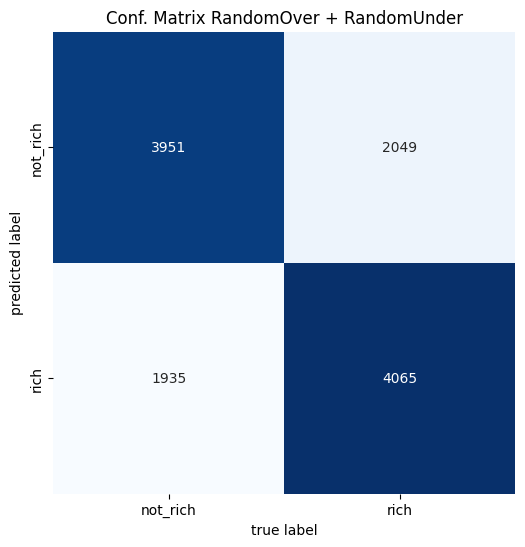

In [18]:
from sklearn.metrics import confusion_matrix

y_pred = lr_model.predict(X_test)

mat = confusion_matrix(y_test, y_pred)
label = ['not_rich','rich']

plt.figure(figsize=(7,6))
plt.title('Conf. Matrix RandomOver + RandomUnder')
sns.heatmap(mat, square=True, annot=True, cbar=False,cmap='Blues',fmt=".4g",xticklabels=label,yticklabels=label)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [19]:
# Per percentuali per riga
confusion_matrix(y_test, y_pred, normalize='true')

array([[0.6585, 0.3415],
       [0.3225, 0.6775]])

In [20]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.67      0.66      0.66      6000
           1       0.66      0.68      0.67      6000

    accuracy                           0.67     12000
   macro avg       0.67      0.67      0.67     12000
weighted avg       0.67      0.67      0.67     12000



## Method 2: Using Predefined Method
### SMOTETomek
SMOTETomek is a hybrid data resampling technique that combines SMOTE (Synthetic Minority Over-sampling Technique) with Tomek Links undersampling. It's used to address class imbalance problems in machine learning datasets

In [21]:
# Combine SMOTE + TomikLinks
from imblearn.combine import SMOTETomek

smote_tk = SMOTETomek()

X_resampled_smtk,y_resampled_smtk = smote_tk.fit_resample(X,y)

In [22]:
print("Original ",X.shape)
print("Balanced X",X_resampled_smtk.shape)
print("Original Y",Counter(y))
print("Balanced Y",Counter(y_resampled_smtk))

Original  (20500, 14)
Balanced X (36706, 14)
Original Y Counter({0: 20000, 1: 500})
Balanced Y Counter({0: 18353, 1: 18353})


In [23]:
#### Cross Value
cv_results_for_smtk = cross_val_score(LogisticRegression(),X_resampled_smtk,y_resampled_smtk,cv=5,scoring='accuracy')
cv_results_for_smtk

array([0.714383  , 0.71856695, 0.7169323 , 0.7188394 , 0.71774963])

In [24]:
np.mean(cv_results_for_smtk)

0.7172942546519028

In [25]:
X_train_smtk,X_test_smtk,y_train_smtk,y_test_smtk = train_test_split(X_resampled_smtk,y_resampled_smtk,
                                                                    test_size=0.3,
                                                                    random_state=667,
                                                                    stratify=y_resampled_smtk,
                                                                    )

In [26]:
lr_model = LogisticRegression()

lr_model.fit(X_train_smtk,y_train_smtk)

LogisticRegression()

In [ ]:
lr_model.score(X_test_smtk,y_test_smtk)

0.7188605642746984

Text(98.33159722222221, 0.5, 'predicted label')

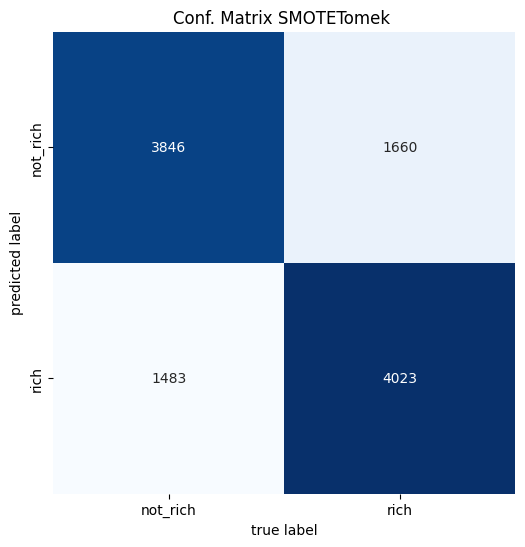

In [27]:
from sklearn.metrics import confusion_matrix

y_pred = lr_model.predict(X_test_smtk)

mat = confusion_matrix(y_test_smtk, y_pred)
label = ['not_rich','rich']

plt.figure(figsize=(7,6))
plt.title('Conf. Matrix SMOTETomek ')
sns.heatmap(mat, square=True, annot=True, cbar=False,cmap='Blues',fmt=".4g",xticklabels=label,yticklabels=label)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [28]:
# Per percentuali per riga
confusion_matrix(y_test_smtk, y_pred, normalize='true')

array([[0.69851072, 0.30148928],
       [0.26934254, 0.73065746]])

In [29]:
print(classification_report(y_test_smtk,y_pred))

              precision    recall  f1-score   support

           0       0.72      0.70      0.71      5506
           1       0.71      0.73      0.72      5506

    accuracy                           0.71     11012
   macro avg       0.71      0.71      0.71     11012
weighted avg       0.71      0.71      0.71     11012



### SMOTEENN: SMOTE with Edited Nearest Neighbor (ENN)
SMOTEENN (SMOTE with Edited Nearest Neighbors) is another hybrid resampling technique that combines SMOTE oversampling with Edited Nearest Neighbors (ENN) undersampling

In [30]:
# Combine SMOTE + ENN
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN()

X_resampled_smenn,y_resampled_smenn = smote_enn.fit_resample(X,y)

In [31]:
print("Original ",X.shape)
print("Balanced X",X_resampled_smenn.shape)
print("Original Y",Counter(y))
print("Balanced Y",Counter(y_resampled_smenn))

Original  (20500, 14)
Balanced X (22349, 14)
Original Y Counter({0: 20000, 1: 500})
Balanced Y Counter({1: 12682, 0: 9667})


In [32]:
#### Cross Value
cv_results_for_smenn = cross_val_score(LogisticRegression(),X_resampled_smenn,y_resampled_smenn,cv=5,scoring='accuracy')
cv_results_for_smenn

array([0.77158837, 0.75816555, 0.77360179, 0.77158837, 0.75318863])

In [33]:
np.mean(cv_results_for_smenn)

0.7656265408784253

In [34]:
X_train_smenn,X_test_smenn,y_train_smenn,y_test_smenn = train_test_split(X_resampled_smenn,y_resampled_smenn,
                                                                        test_size=0.3,
                                                                        random_state=667,
                                                                        stratify=y_resampled_smenn,
                                                                        )

In [35]:
lr_model = LogisticRegression()

lr_model.fit(X_train_smenn,y_train_smenn)

LogisticRegression()

In [36]:
lr_model.score(X_test_smenn,y_test_smenn)

0.7568978374347501

Text(98.33159722222221, 0.5, 'predicted label')

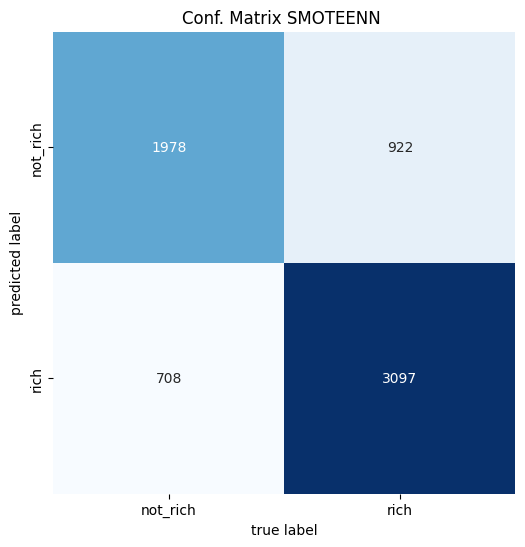

In [37]:
from sklearn.metrics import confusion_matrix

y_pred = lr_model.predict(X_test_smenn)

mat = confusion_matrix(y_test_smenn, y_pred)
label = ['not_rich','rich']

plt.figure(figsize=(7,6))
plt.title('Conf. Matrix SMOTEENN ')
sns.heatmap(mat, square=True, annot=True, cbar=False,cmap='Blues',fmt=".4g",xticklabels=label,yticklabels=label)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [38]:
# Per percentuali per riga
confusion_matrix(y_test_smenn, y_pred, normalize='true')

array([[0.68206897, 0.31793103],
       [0.18607096, 0.81392904]])

In [ ]:
print(classification_report(y_test_smenn,y_pred))

              precision    recall  f1-score   support

           0       0.76      0.68      0.72      2874
           1       0.77      0.83      0.80      3760

    accuracy                           0.77      6634
   macro avg       0.77      0.76      0.76      6634
weighted avg       0.77      0.77      0.77      6634



### Comparing SMOTETomek,SMOTEENN with SMOTE

In [39]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_resampled_sm,y_resampled_sm = smote.fit_resample(X,y)

In [ ]:
print("Original ",X.shape)
print("Balanced X",X_resampled_sm.shape)
print("Original Y",Counter(y))
print("Balanced Y",Counter(y_resampled_sm))

Original  (20500, 14)
Balanced X (40000, 14)
Original Y Counter({0: 20000, 1: 500})
Balanced Y Counter({0: 20000, 1: 20000})


In [40]:
#### Cross Value
cv_results_for_sm = cross_val_score(LogisticRegression(),X_resampled_sm,y_resampled_sm,cv=5,scoring='accuracy')
cv_results_for_sm

array([0.707125, 0.711375, 0.717   , 0.7045  , 0.709875])

In [41]:
np.mean(cv_results_for_sm)

0.709975

In [42]:
X_train_sm,X_test_sm,y_train_sm,y_test_sm = train_test_split(X_resampled_sm,y_resampled_sm,
                                                            test_size=0.3,
                                                            random_state=667,
                                                            stratify=y_resampled_sm,
                                                            )

In [43]:
lr_model = LogisticRegression()

lr_model.fit(X_train_sm,y_train_sm)

LogisticRegression()

Text(98.33159722222221, 0.5, 'predicted label')

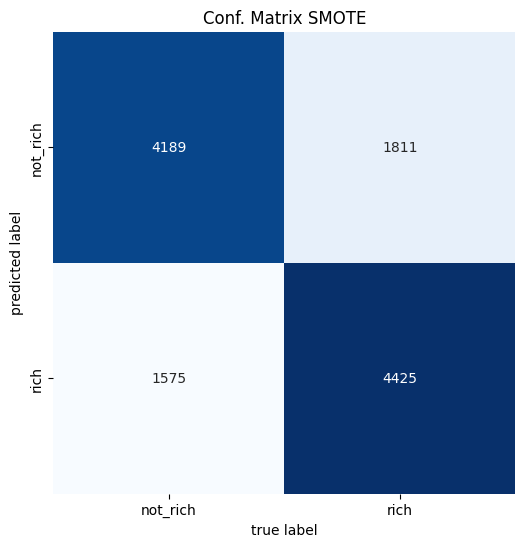

In [44]:
from sklearn.metrics import confusion_matrix

y_pred = lr_model.predict(X_test_sm)

mat = confusion_matrix(y_test_sm, y_pred)
label = ['not_rich','rich']

plt.figure(figsize=(7,6))
plt.title('Conf. Matrix SMOTE')
sns.heatmap(mat, square=True, annot=True, cbar=False,cmap='Blues',fmt=".4g",xticklabels=label,yticklabels=label)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [45]:
# Per percentuali per riga
confusion_matrix(y_test_sm, y_pred, normalize='true')

array([[0.69816667, 0.30183333],
       [0.2625    , 0.7375    ]])

In [46]:
print(classification_report(y_test_sm,y_pred))

              precision    recall  f1-score   support

           0       0.73      0.70      0.71      6000
           1       0.71      0.74      0.72      6000

    accuracy                           0.72     12000
   macro avg       0.72      0.72      0.72     12000
weighted avg       0.72      0.72      0.72     12000



The predefined combined (SMOTEENN gave us a higher accuracy thant the single smote)